<h1>Прогнозирование энергопотребления в Калининградской области<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Формирование-базы-данных" data-toc-modified-id="Формирование-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Формирование базы данных</a></span></li><li><span><a href="#Выделение-обучающего,-тестового-и-валидационного-фреймов" data-toc-modified-id="Выделение-обучающего,-тестового-и-валидационного-фреймов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выделение обучающего, тестового и валидационного фреймов</a></span></li><li><span><a href="#Разведочный-анализ-данных-(EDA)" data-toc-modified-id="Разведочный-анализ-данных-(EDA)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разведочный анализ данных (EDA)</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li><li><span><a href="#Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности" data-toc-modified-id="Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности</a></span><ul class="toc-item"><li><span><a href="#Оценка-(грубая)-модели-на-валидационных-данных" data-toc-modified-id="Оценка-(грубая)-модели-на-валидационных-данных-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Оценка (грубая) модели на валидационных данных</a></span></li></ul></li><li><span><a href="#Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона" data-toc-modified-id="Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Обучение с фильтрацией исходных признаков и временного диапазона</a></span><ul class="toc-item"><li><span><a href="#Оценка-модели-на-тестовых-данных-(январь-октябрь-2023)" data-toc-modified-id="Оценка-модели-на-тестовых-данных-(январь-октябрь-2023)-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Оценка модели на тестовых данных (январь-октябрь 2023)</a></span></li><li><span><a href="#Оценка-(грубая)-модели-на-валидационных-данных-(ноябрь-декабрь-2023)" data-toc-modified-id="Оценка-(грубая)-модели-на-валидационных-данных-(ноябрь-декабрь-2023)-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Оценка (грубая) модели на валидационных данных (ноябрь-декабрь 2023)</a></span></li></ul></li><li><span><a href="#Посуточное-обучение-и-валидация" data-toc-modified-id="Посуточное-обучение-и-валидация-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Посуточное обучение и валидация</a></span></li></ul></li></ul></div>

# Используемые ресурсы

In [1]:
import re
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb

from datetime import datetime
from tqdm.notebook import trange
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Формирование базы данных

*Загрузка данных о погодных условиях*

In [2]:
# создаём датафрейм с погодными условиями
meteo_df = pd.read_excel("Метео 2013-2023.xlsx")

meteo_df = meteo_df.iloc[3:, [1, 2, 3, 4, 5]].reset_index(drop=True)
meteo_df.columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature']

meteo_df['Year'] = meteo_df['Year'].interpolate(method='pad').astype(int)
meteo_df['Month'] = meteo_df['Month'].interpolate(method='pad')
meteo_df['Day'] = meteo_df['Day'].interpolate(method='pad')

meteo_df = meteo_df.dropna(subset=['Hour']).reset_index(drop=True)

meteo_df['Hour'] = meteo_df['Hour'].astype(int)
meteo_df['Temperature'] = meteo_df['Temperature'].astype(float)
meteo_df['Day'] = meteo_df['Day'].apply(lambda x: x.split(' ')[0]).astype(int)

meteo_df['Month'] = meteo_df['Month'].map({'январь': 1, 'февраль': 2, 'март': 3, 'апрель': 4, 'май': 5, 'июнь': 6,
                   'июль': 7, 'август': 8, 'сентябрь': 9, 'октябрь': 10, 'ноябрь': 11, 'декабрь': 12})

*Загрузка данных об энергопотреблении*

In [3]:
volume_df_raw = pd.read_excel("ИСП 2013-2023.xlsx", index_col=0)

# создаём датафрейм с данными об энергопотреблении
volume_df = pd.DataFrame()

list_columns_raw = volume_df_raw.iloc[0].tolist()
list_columns = list()

for date in list_columns_raw:
    for _ in range(24):  # генерируем пространство под часы
        list_columns.append(re.search(r'\d{2}\.\d{2}\.\d{2}', date)[0])  # парсим даты из 0-й строки фрейма 

volume_df_raw.columns = volume_df_raw.iloc[0]  # переопределяем названия столбцов
volume_df_raw = volume_df_raw.iloc[2:-6]       # удаляем лишние значения с последующей переиндексацией
volume_df_raw.reset_index(drop=True, inplace=True)

volume_df['Date'] = pd.Series(list_columns)
volume_df['Date'] = pd.to_datetime(volume_df['Date'], dayfirst=True)
volume_df['Year'] = volume_df['Date'].dt.year
volume_df['Month'] = volume_df['Date'].dt.month
volume_df['Day'] = volume_df['Date'].dt.day
volume_df['Hour'] = volume_df_raw.index.astype(int).to_list() * volume_df_raw.shape[1]
volume_df['Weekday'] = volume_df['Date'].dt.weekday  # добавляем день недели 
volume_df['Volume'] = np.array([value for name, value in volume_df_raw.items()]).ravel()
volume_df['Volume'] = volume_df['Volume'].astype(float) 

# отсекаем дни с неполными или отсутсвующими данными (с 10.12.23)
volume_df = volume_df[volume_df['Date'] < datetime(2023,12,10)]

volume_df.drop(columns='Date', inplace=True)

In [4]:
# объединяем полученные датафреймы по дате
df = volume_df.merge(meteo_df, how='left')

# интерполируем пропуски (линейная, полиноминальная 3 порядка)
df['Temperature'] = df['Temperature'].interpolate(method='polynomial', order=3).round(1)

# экстраполируем температуры для первой и двух последних записей соседними значениями
df['Temperature'] = df['Temperature'].interpolate(method='nearest', axis=0).ffill().bfill()

# сохраняем базу данных в xlsx-файл
df.to_excel('DataBase.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95880 entries, 0 to 95879
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         95880 non-null  int64  
 1   Month        95880 non-null  int64  
 2   Day          95880 non-null  int64  
 3   Hour         95880 non-null  int64  
 4   Weekday      95880 non-null  int64  
 5   Volume       93699 non-null  float64
 6   Temperature  95880 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 5.9 MB


# Выделение обучающего, тестового и валидационного фреймов

Объём используемых данных:
* **Генеральная** совокупность: 01.01.2013 – 31.10.2023 
* **Тестовая** выборка: 01.01.2023 – 31.10.2023
* **Валидационная** выборка: 01.11.2023 – 09.12.2023

In [5]:
# для работы с готовой БД раскомментируйте строки ниже 
#df = pd.read_excel('DataBase.xlsx')
#df.drop(df.columns[0], axis=1 , inplace=True)

In [6]:
def prepareData(df, lag_start, lag_end):        
    
    # восстанавливаем пропуски данных (3 записи) с помощью линейной интерполяции
    df[df['Year']!=2013] = df[df['Year']!=2013].interpolate(method='linear')
    
    # добавляем суточные лаги исходного ряда
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(i*24)   
        
    # удаляем первые 168 (7 * 24) записей с пропусками данных + 2178 пустых значений в 2013 году
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    
    return df

*Подумать над восстановлением данных в 2014 и 2015 годах*

In [7]:
# формируем генеральную совокупность
df_general = df.copy()

# добавляем новые признаки и удаляем пропуски в данных
df_general = prepareData(df_general, 1, 7)

# формируем тестовую выборку (01.01.2023 – 31.10.2023)
df_test = df_general[df_general['Year'] == datetime.now().year - 1]
df_test = df_test[df_test['Month'] < 11]                                 # убрать строку при наличии данных за 2024 год
df_test.reset_index(drop=True, inplace=True)

# формируем валидационную выборку (01.11.2023 – 09.12.2023)
df_validate = df_general[df_general['Year'] == datetime.now().year - 1]  # при наличии данных за 2024 год убрать "-1"
df_validate = df_validate[df_validate['Month'] > 10]                     # убрать строку при наличии данных за 2024 год
df_validate.reset_index(drop=True, inplace=True)

# исключаем валидационную выборку из генеральной совокупности
df_general = pd.concat([df_general, df_validate]).drop_duplicates(keep=False)

In [8]:
df_general

,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,0,1,619.0,-3.0,616.0,616.0,597.0,585.0,573.0,566.0,578.0
1,2013,1,8,1,1,577.0,-3.1,578.0,570.0,553.0,543.0,537.0,527.0,551.0
2,2013,1,8,2,1,538.0,-3.1,541.0,534.0,516.0,505.0,501.0,497.0,541.0
3,2013,1,8,3,1,510.0,-3.2,515.0,505.0,487.0,482.0,478.0,475.0,514.0
4,2013,1,8,4,1,490.0,-3.3,497.0,485.0,471.0,466.0,459.0,458.0,488.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91913,2023,10,31,19,1,655.0,13.3,647.0,686.0,675.0,689.0,681.0,682.0,650.0
91914,2023,10,31,20,1,648.0,13.3,644.0,675.0,669.0,680.0,675.0,674.0,648.0
91915,2023,10,31,21,1,632.0,13.2,634.0,654.0,648.0,659.0,663.0,652.0,637.0
91916,2023,10,31,22,1,608.0,12.7,613.0,636.0,630.0,641.0,637.0,633.0,618.0


In [9]:
df_test

,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2023,1,1,0,6,540.0,12.7,586.0,593.0,608.0,613.0,609.0,609.0,609.0
1,2023,1,1,1,6,510.0,12.8,553.0,550.0,561.0,565.0,570.0,568.0,578.0
2,2023,1,1,2,6,502.0,12.4,515.0,515.0,529.0,531.0,532.0,538.0,544.0
3,2023,1,1,3,6,488.0,11.9,486.0,494.0,509.0,517.0,519.0,518.0,528.0
4,2023,1,1,4,6,477.0,11.4,476.0,484.0,499.0,507.0,505.0,513.0,514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,2023,10,31,19,1,655.0,13.3,647.0,686.0,675.0,689.0,681.0,682.0,650.0
7292,2023,10,31,20,1,648.0,13.3,644.0,675.0,669.0,680.0,675.0,674.0,648.0
7293,2023,10,31,21,1,632.0,13.2,634.0,654.0,648.0,659.0,663.0,652.0,637.0
7294,2023,10,31,22,1,608.0,12.7,613.0,636.0,630.0,641.0,637.0,633.0,618.0


In [10]:
df_validate

,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2023,11,1,0,2,547.0,11.3,552.0,568.0,569.0,586.0,574.0,564.0,564.0
1,2023,11,1,1,2,509.0,11.0,509.0,523.0,535.0,544.0,526.0,526.0,518.0
2,2023,11,1,2,2,477.0,10.8,480.0,496.0,506.0,508.0,498.0,497.0,483.0
3,2023,11,1,3,2,465.0,10.4,464.0,473.0,492.0,488.0,483.0,484.0,472.0
4,2023,11,1,4,2,457.0,9.7,454.0,467.0,484.0,479.0,480.0,471.0,461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2023,12,9,19,5,781.0,-3.5,788.0,785.0,798.0,771.0,771.0,765.0,751.0
932,2023,12,9,20,5,766.0,-3.4,775.0,775.0,779.0,764.0,761.0,756.0,736.0
933,2023,12,9,21,5,745.0,-3.2,753.0,755.0,760.0,752.0,743.0,739.0,716.0
934,2023,12,9,22,5,731.0,-3.2,735.0,738.0,738.0,732.0,718.0,721.0,704.0


# Разведочный анализ данных (EDA)

*График структуры (усредненной по дням недели) потребления электрической энергии за 10 лет*

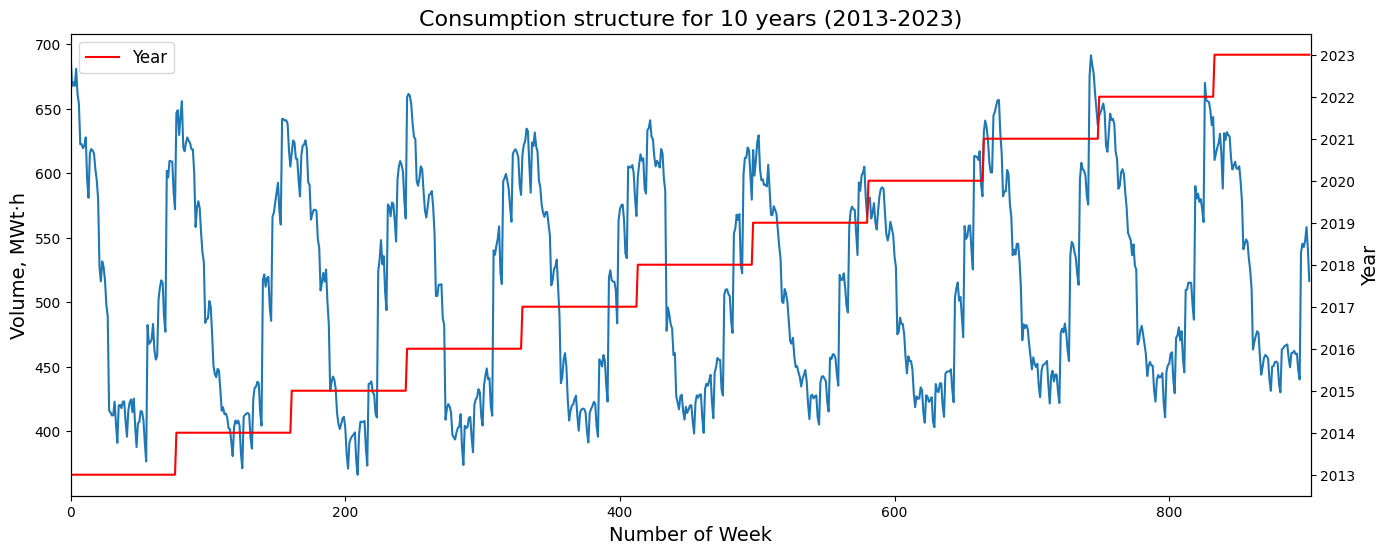

In [23]:
df_general_group = df_general.groupby(['Year', 'Month', 'Weekday'])[['Volume']].mean()
df_general_group.reset_index(inplace=True)
#df_general_group = df_general.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,6))
df_year = df_volume.twinx()

df_volume.plot(df_general_group['Volume'], label='Volume')
df_year.plot(df_general_group['Year'], label='Year', color='red')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_general_group.shape[0])
#df_volume.set_ylim(df_general_group['Volume'].min(), df_general_group['Volume'].max())  # диапазон 'volume' от min до max
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Week', fontsize = 14)
df_year.set_ylabel('Year', fontsize = 14)
df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

plt.title(f'Сonsumption structure for 10 years (2013-{datetime.now().year-1})', fontsize = 16)
plt.legend()

*График структуры (усредненной по дням) потребления электрической энергии за 2023 год*

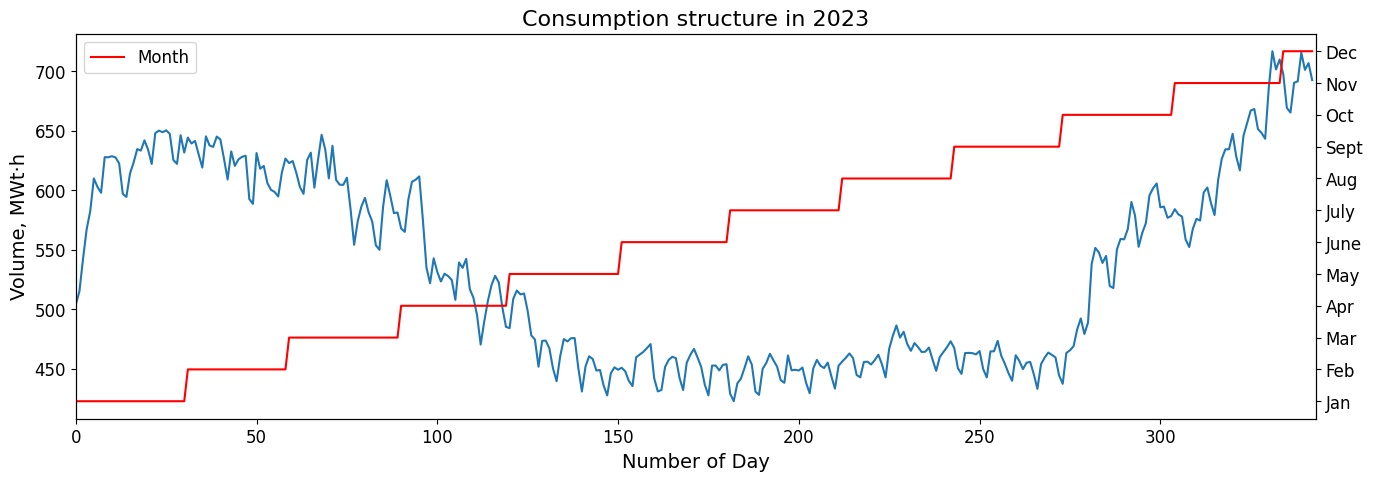

In [24]:
df_last_year = df[df['Year'] == datetime.now().year - 1]  # использовать, пока не появится полный датасет
#df_last_year = df_general[df_general['Year'] == datetime.now().year - 1]
df_last_year.reset_index(drop=True, inplace=True)

df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume']].mean()
df_group_last_year.reset_index(inplace=True)
#df_group_last_year = df_last_year.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,5))
df_month = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], label='Volume')
df_month.plot(df_group_last_year['Month'], label='Month', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Day', fontsize = 14)
df_month.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 13)]))
df_month.yaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))

plt.title(f'Сonsumption structure in {datetime.now().year - 1}', fontsize = 16)
plt.legend()

*График зависимости усреднённой по дням температуры с усреднённым по дням потреблением ЭЭ для 2023 года*

Text(0.5, 1.0, 'Graph of average daily consumption and average daily temperature for 2023')

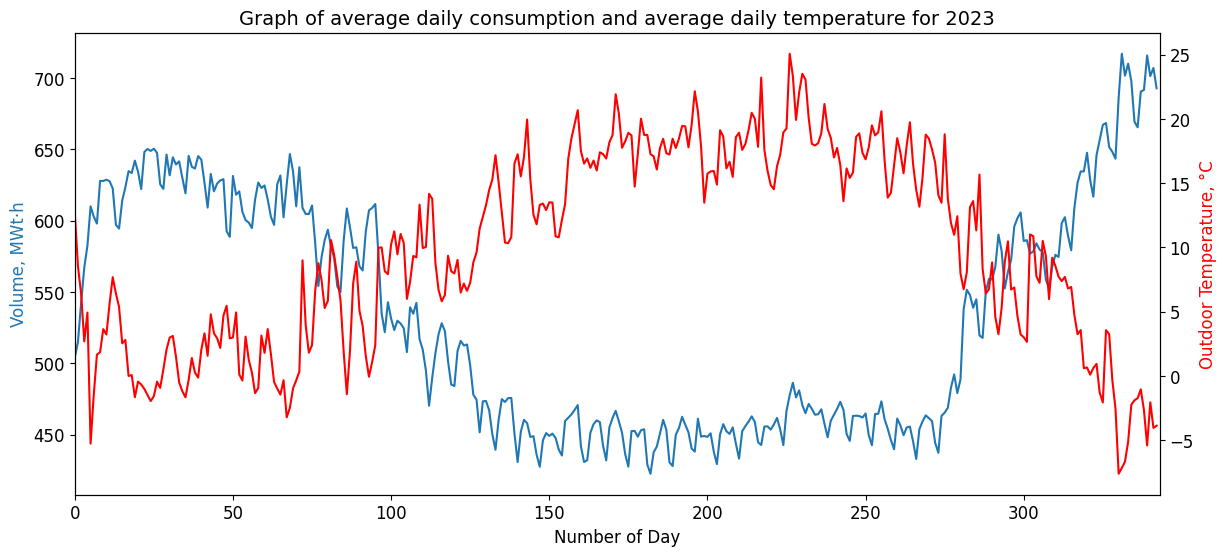

In [42]:
df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume', 'Temperature']].mean()
df_group_last_year.reset_index(drop=True, inplace=True) 

fig, df_volume = plt.subplots(figsize=(14,6))
df_temperature = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], color='#1f77b4', label='Volume')

df_temperature.plot(df_group_last_year['Temperature'], color = 'red', label = 'Temperature')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 12, color='#1f77b4')
df_volume.set_xlabel('Number of Day', fontsize = 12)
df_temperature.set_ylabel('Outdoor Temperature, °C', fontsize = 12, color='red')

plt.title(f'Graph of average daily consumption and average daily temperature for {datetime.now().year-1}', fontsize = 14)

**Вывод**: Наблюдается отчетливая корреляция между температурой наружного воздуха и объемом электропотребления

**Примечание**: 343 строки вместо 365, поскольку нет данных с 10 по 31 декабря 2023

*График структуры потребления электрической энергии по дням недели в течении месяца*

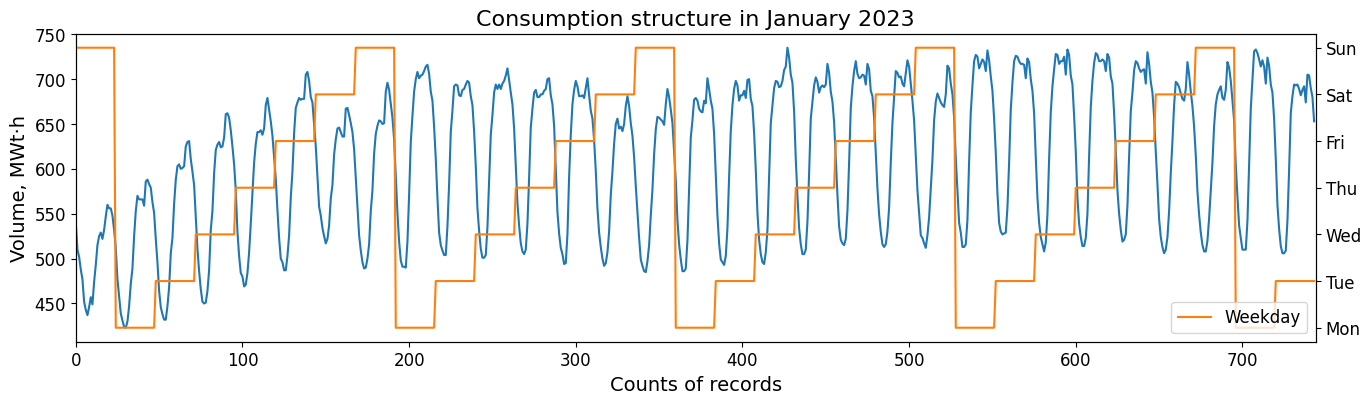

In [29]:
month = list(name for name in calendar.month_name)

df_month = df_test[df_test['Month'] == 1]  # указываем интересующий нас месяц
df_month.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_weekday = df_volume.twinx()

df_volume.plot(df_month['Volume'], label='Volume')
df_weekday.plot(df_month['Weekday'], label='Weekday', color='#ff7f0e')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_month.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

plt.title(f'Сonsumption structure in {month[df_month.Month[0]]} {datetime.now().year-1}', fontsize = 16)
plt.legend(loc = 'lower right')

*Корреляция числовых и категориальных признаков*

In [144]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df_gen = df_general[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature', 'Volume']]

df_gen.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)
#sns.heatmap(df_gen.corr(), annot=True, cmap=color_map, fmt=".3f")  # графическая версия таблицы

,Year,Month,Day,Hour,Weekday,Temperature,Volume
Year,1.000000,0.003826,-0.005689,0.002331,0.001357,0.042648,0.060613
Month,0.003826,1.000000,0.012578,0.000435,-0.001496,0.255466,-0.160378
Day,-0.005689,0.012578,1.000000,0.000151,0.000516,0.015247,0.018225
Hour,0.002331,0.000435,0.000151,1.000000,0.000240,0.163664,0.458401
Weekday,0.001357,-0.001496,0.000516,0.000240,1.000000,0.002411,-0.071562
Temperature,0.042648,0.255466,0.015247,0.163664,0.002411,1.000000,-0.546073
Volume,0.060613,-0.160378,0.018225,0.458401,-0.071562,-0.546073,1.000000


**Вывод**: ощутимая корреляционная связь объема c часом и температурой

# XGBoost

## Оценка ценности признаков

In [47]:
# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df_general.drop(columns='Volume'), df_general['Volume'])

features_table = pd.DataFrame(result.feature_importances_, 
                              index = df_general.drop(columns='Volume').columns, 
                              columns = ['importance'])

features_table = features_table.sort_values(by='importance', ascending=False).T
features_table

,lag-1,lag-7,lag-6,Weekday,Hour,lag-3,Temperature,Month,Day,lag-4,Year,lag-2,lag-5
importance,0.887251,0.054335,0.024096,0.01088,0.004656,0.004417,0.004222,0.003567,0.001985,0.001423,0.001286,0.00099,0.00089


In [57]:
# исследуемый список датасетов с учетом ценности признаков
dataset = list([df_general.drop(columns='Volume').columns,
                df_general.drop(columns=[features_table.columns[-1], 'Volume']).columns,
                df_general.drop(columns=[features_table.columns[-1], features_table.columns[-2], 'Volume']).columns])

# удаляем два крайних малозначимых признака
predictions = list(['Predicted',  
                    'Predicted_1c', 
                    'Predicted_2c'])

messages = list([f'Full set:',
                 f'Without {features_table.columns[-1]}',
                 f'Without {features_table.columns[-1]} & {features_table.columns[-2]}'])

## Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности
Обучение выполняется по методике, описанной в [статье](https://www.mdpi.com/2411-5134/8/5/114): валидация 1 к 3, количество деревьев `n_estimators` – 100, генеральная совокупность данных – за 3 года

In [59]:
%%time

# поиск лучших гиперпараметров XGBoost с помощью сетки гиперпараметров
df_boost_train = df_general[df_general['Year'] > 2020]  # формируем обучающий датафрейм
df_boost_test = df_test.copy()

XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 10)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

XGB_best = XGB_search.best_estimator_

XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

# Предсказываем объемы потребления
df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

hyper_params = XGB_best.get_params()
print(f"max_depth: {hyper_params['max_depth']}, n_estimators: {hyper_params['n_estimators']}")

print()

MAE: 6.19 [MW] 
MAPE: 1.21%
max_depth: 5, n_estimators: 100

CPU times: total: 32.1 s
Wall time: 12.7 s


### Оценка (грубая) модели на валидационных данных

In [60]:
# Грубая валидация без сокрытия данных на текущие сутки (для скоростной проверки гипотезы)

df_boost_test = df_validate.copy()

df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

#df_boost_test

MAE: 10.42 [MW] 
MAPE: 1.66%


## Обучение с фильтрацией исходных признаков и временного диапазона
Всё то же обучение на потерях тестовых данных при кросс-валидации генеральной совокупности, но с более широким настроечным диапазоном

In [61]:
%%time

# инициализируем итоговый датафрейм по всем временным интервалам (3-11 лет)
df_general_result = pd.DataFrame({'period':[],  # рассматриваемый временной интервал
                                  'set': [],  # тип датасета
                                  'MAE [MW]':[],  # минимальная средняя абсолютная ошибка
                                  'MAPE':[],  # минимальная средняя относительная ошибка
                                  'max_depth':[],  # оптимальная глубина дерева
                                  'n_estimators':[]})  # оптимальное количество деревьев

index = 0  # индекс узла сетки итогового датафрейма

df_boost_test = df_test.copy()

for time in trange(2021, 2012, -1, desc=f"period progress"):  # виджет процесса расчёта оптимальных гиперпараметров

    df_boost_train = df_general[df_general['Year'] >= time]  # формируем обучающий датафрейм под рассматриваемый интервал

    for data in range(len(dataset)):  # выбор датасета

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 8)}, 
                          scoring='neg_mean_absolute_percentage_error',
                          verbose = 0,
                          cv=5)

        XGB_search.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)
        
        df_boost_test[predictions[data]] = XGB_best.predict(df_boost_test[dataset[data]])
        
        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time, messages[data], 
                                        MAE(df_boost_test[predictions[data]], df_boost_test['Volume']), 
                                        MAPE(df_boost_test[predictions[data]], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

period progress:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 21min 8s
Wall time: 5min 44s


*Полученная комбинация оптимальных гиперпараметров при различной глубине временного интервала заданных датасетов*

In [62]:
i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
            'index': messages.index(df_general_result.set[i]),  # индекс оптимального датасета
            'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
            'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

print(best_HP)

df_general_result.style.highlight_min(color='yellowgreen', subset='MAPE')

{'period': 8, 'index': 2, 'max_depth': 7, 'n_estimators': 100}


,period,set,MAE [MW],MAPE,max_depth,n_estimators
0,3,Full set:,7.088652,0.013754,4,100
1,3,Without lag-5,6.987541,0.013549,4,100
2,3,Without lag-5 & lag-2,8.057346,0.015545,3,100
3,4,Full set:,7.101068,0.013765,4,100
4,4,Without lag-5,7.193125,0.013940,4,100
5,4,Without lag-5 & lag-2,7.138305,0.013833,4,100
6,5,Full set:,5.484905,0.010816,6,100
7,5,Without lag-5,7.322091,0.014179,4,100
8,5,Without lag-5 & lag-2,7.404735,0.014333,4,100
9,6,Full set:,5.740452,0.011288,6,100


In [126]:
# ручная донастройка гиперпараметров
best_HP = {'period': 5,   # оптимальный временной период
            'index': 0,  # индекс оптимального датасета
            'max_depth': 4,   # отпимальная глубина дерева
            'n_estimators': 100}  # оптимальное колличество деревьев

*Предельные показатели метрики MAPE при различной глубине исследуемого интервала*

{'period': 5, 'index': 0, 'max_depth': 4, 'n_estimators': 100}


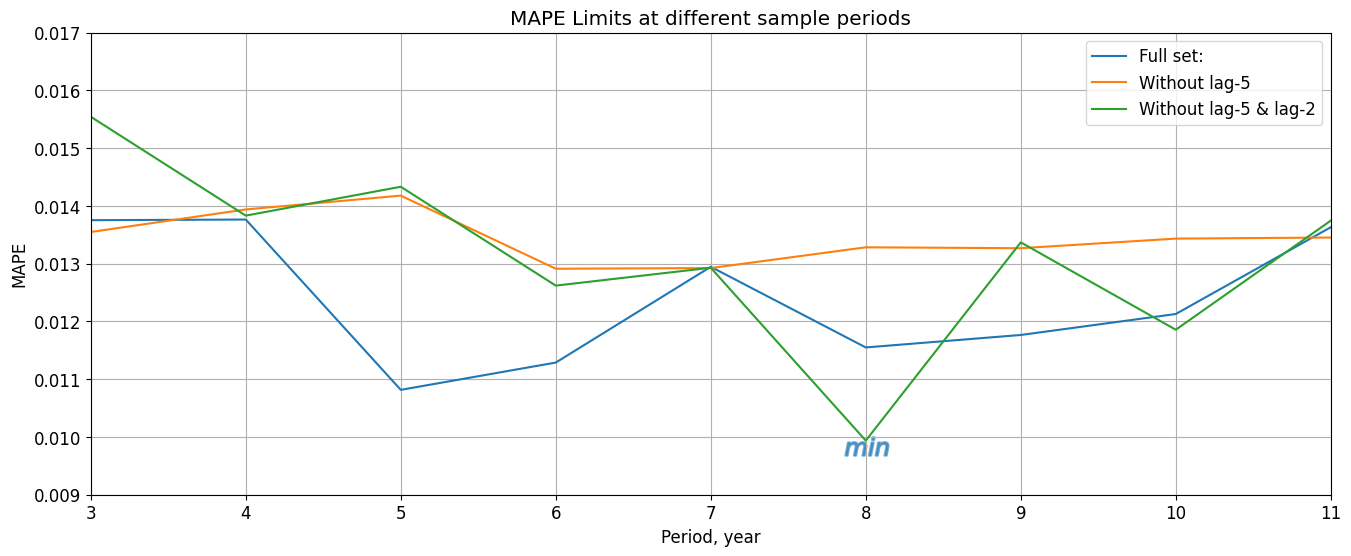

In [130]:
plot_gen = list()
for i in range(len(messages)):
    plot_gen.append(df_general_result[df_general_result['set'] == messages[i]])
    plot_gen[i]=plot_gen[i][['period', 'MAPE']]
    plot_gen[i].set_index('period', inplace= True)
    plot_gen[i] = plot_gen[i].rename(columns={'MAPE': messages[i]})

pd.concat([plot_gen[i] for i in range(3)], axis=1).plot(figsize=(16,6), 
                                                        title='MAPE Limits at different sample periods',
                                                        xlim=(df_general_result.period.min(), 
                                                              df_general_result.period.max()), 
                                                        ylim=(round(df_general_result.MAPE.min(), 3) - 0.001, 
                                                              round(df_general_result.MAPE.max(), 3) + 0.001),
                                                        xlabel='Period, year',
                                                        ylabel='MAPE',
                                                        legend=True,
                                                        grid=True)

plt.scatter(df_general_result.period[df_general_result.MAPE.idxmin()], 
            df_general_result.MAPE.min()-0.0001,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

print(best_HP)

**Выводы**: 
1. Фильтрация исходных признаков лишено всякого смысла
2. Оптимальный размер обучающей выборки: 5-6 лет
3. Оптимальная глубина дерева: 2-6 веток

### Оценка модели на тестовых данных (январь-октябрь 2023)

*Оценка прогнозирования за 2023 год при оптимальных гиперпараметрах с разбивкой по месяцам*

In [127]:
%%time

df_boost_test = df_test.copy()  # формируем тестовый датафрейм
df_boost_train = df_general[df_general['Year'] > datetime.now().year - best_HP['period'] - 1]  # формируем обучающий датафрейм

# обучаем модель
model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                         n_estimators = best_HP['n_estimators'],
                         max_depth = best_HP['max_depth'])

model.fit(df_boost_train[dataset[best_HP['index']]], df_boost_train['Volume'])
df_boost_test[predictions[best_HP['index']]] = model.predict(df_boost_test[dataset[best_HP['index']]])

CPU times: total: 1.44 s
Wall time: 383 ms


In [128]:
month = list(name for name in calendar.month_name)

df_month_result = pd.DataFrame({'Month':[],
                                'MAE [MW]':[],
                                'MAPE':[]})

for i in range(12):
    df_month = df_boost_test[df_boost_test['Month'] == i + 1]
    if df_month.shape[0]:
        df_month_result.loc[i] = (month[i + 1],
                                  f"{MAE(df_month[predictions[best_HP['index']]], df_month['Volume']):.2f}", 
                                  f"{MAPE(df_month[predictions[best_HP['index']]], df_month['Volume']):.3%}")

df_month_result = pd.concat([df_month_result, 
                             pd.DataFrame({'Month': 'Average', 
                                           'MAE [MW]': f"{MAE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.2f}", 
                                           'MAPE': f"{MAPE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.3%}"}, 
                             index = [0])])

df_month_result.set_index('Month').T

Month,January,February,March,April,May,June,July,August,September,October,Average
MAE [MW],7.90,8.48,8.89,9.09,8.38,5.79,5.42,5.66,5.73,8.10,7.34
MAPE,1.316%,1.356%,1.475%,1.731%,1.819%,1.281%,1.220%,1.241%,1.248%,1.509%,1.420%


### Оценка (грубая) модели на валидационных данных (ноябрь-декабрь 2023)
*Прогнозирование на месяц вперед*

In [129]:
# Предсказываем объемы потребления на валидационной выборке
df_validate_boost = df_validate.copy()

df_validate_boost[predictions[best_HP['index']]] = model.predict(df_validate_boost[dataset[best_HP['index']]])

# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2%}")

df_validate_boost

MAE: 9.14 [MW] 
MAPE: 1.44%


,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,Predicted
0,2023,11,1,0,2,547.0,11.3,552.0,568.0,569.0,586.0,574.0,564.0,564.0,551.781006
1,2023,11,1,1,2,509.0,11.0,509.0,523.0,535.0,544.0,526.0,526.0,518.0,517.141724
2,2023,11,1,2,2,477.0,10.8,480.0,496.0,506.0,508.0,498.0,497.0,483.0,485.186340
3,2023,11,1,3,2,465.0,10.4,464.0,473.0,492.0,488.0,483.0,484.0,472.0,470.139771
4,2023,11,1,4,2,457.0,9.7,454.0,467.0,484.0,479.0,480.0,471.0,461.0,456.478333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2023,12,9,19,5,781.0,-3.5,788.0,785.0,798.0,771.0,771.0,765.0,751.0,765.521118
932,2023,12,9,20,5,766.0,-3.4,775.0,775.0,779.0,764.0,761.0,756.0,736.0,762.839600
933,2023,12,9,21,5,745.0,-3.2,753.0,755.0,760.0,752.0,743.0,739.0,716.0,751.682556
934,2023,12,9,22,5,731.0,-3.2,735.0,738.0,738.0,732.0,718.0,721.0,704.0,741.447144


*Сравнение прогнозных значений с фактическими*

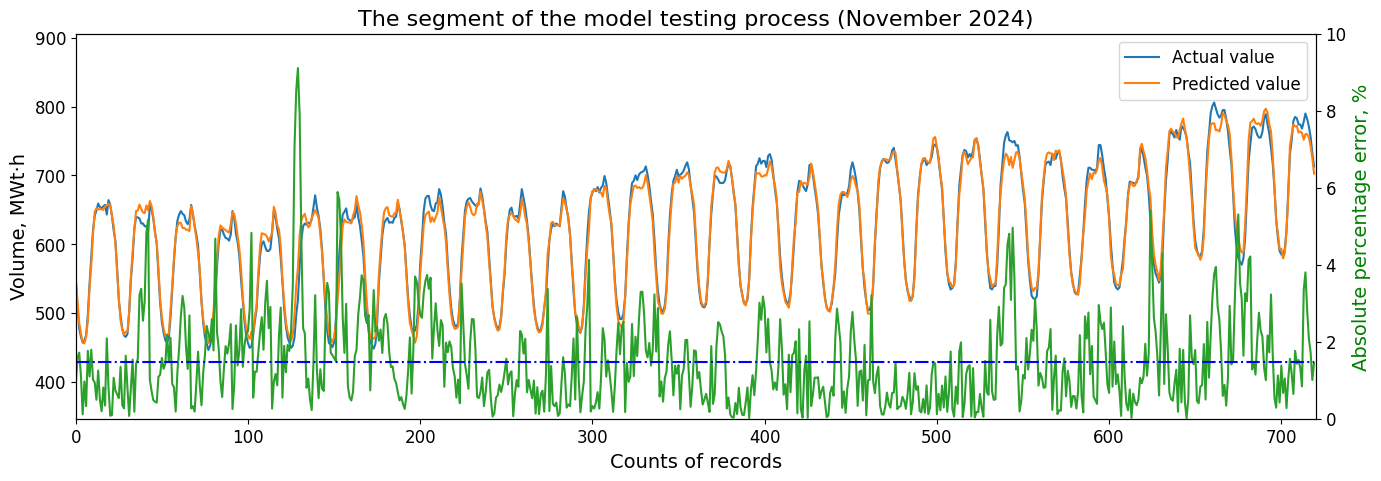

In [138]:
# приводим название столбца Prediction для фильтрованных данных к общему виду
df_validate_boost = df_validate_boost.rename(columns={predictions[best_HP['index']]:'Predicted'})

def diff_predict_vs_fact(df_validate_boost, num_month):
    
    df_validate_graph = df_validate_boost[df_validate_boost['Month'] == num_month].copy()

    # добавление новых столбцов (для расчёта усреднённой погрешности)
    df_validate_graph.insert(df_validate_graph.shape[1], 'MAPE', 
                             MAPE(df_validate_graph['Predicted'], df_validate_graph['Volume'])*100)

    df_validate_graph['Error'] = abs((df_validate_graph['Volume'] - df_validate_graph['Predicted'])*100
                                 /df_validate_graph['Volume'])

    df_validate_graph.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate_graph['Volume'], label='Actual value')
    df_volume.plot(df_validate_graph['Predicted'], label='Predicted value')
    df_error.plot(df_validate_graph['Error'], label='Error, %', color='#2ca02c')
    df_error.plot(df_validate_graph['MAPE'], '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate_graph.shape[0])
    df_volume.set_ylim(df_validate_graph.Volume.min() - 100, df_validate_graph.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    plt.title(f'The segment of the model testing process ({month[df_validate_graph.Month[0]]} {datetime.now().year})', 
              fontsize = 16)
    
diff_predict_vs_fact(df_validate_boost, 11)
#diff_predict_vs_fact(df_validate_boost, 12)

## Посуточное обучение и валидация
*Прогнозирование на сутки вперед: данные доступны до 11:00 AM минус первых суток*

In [139]:
def search_HP(df_boost_general, df_test):                  # df_boost_general -> df_boost_general_cut
    df_general_result = pd.DataFrame({'period':[],         # рассматриваемый временной интервал
                                      'MAE [MW]':[],       # минимальная средняя абсолютная ошибка
                                      'MAPE':[],           # минимальная средняя относительная ошибка
                                      'max_depth':[],      # оптимальная глубина дерева
                                      'n_estimators':[]})  # оптимальное количество деревьев

    index = 0  # индекс узла сетки итогового датафрейма

    for time in range(2020, 2015, -1):  # временной диапазон выборки: 4-8 лет

        df_boost_test = df_test.copy()
        df_boost_train = df_boost_general[df_boost_general['Year'] >= time]

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100),
                                  param_grid={'max_depth': range(3, 6)}, 
                                  scoring='neg_mean_absolute_percentage_error',
                                  verbose = 0,
                                  cv=5)

        XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time,
                                        MAE(df_boost_test['Predicted'], df_boost_test['Volume']), 
                                        MAPE(df_boost_test['Predicted'], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

    i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

    best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
               'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
               'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

    return best_HP

In [140]:
def predict_volume(df_boost_general_cut, df_boost_validate, best_HP):

    # формируем оптимальную обучающую выборку
    df_boost_train = df_boost_general_cut[df_boost_general_cut['Year'] > datetime.now().year - best_HP['period'] - 1]

    # обучаем модель
    model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                             n_estimators = int(best_HP['n_estimators']),
                             max_depth = int(best_HP['max_depth']))

    model.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

    # прогнозируем объёмы потребления на ближайшие сутки
    df_boost_validate['Predicted'] = model.predict(df_boost_validate.drop(columns='Volume'))
   
    return df_boost_validate

In [141]:
%%time

df_boost_general = df_general.copy()

# итоговый валидационный датафрейм с прогнозными значениями
df_validate_result = pd.DataFrame(columns=df_validate.columns)

for i in trange(int((df_validate.shape[0] + 1) / 24), desc=f"days progress"):  # виджет процесса расчёта по суткам
    
    # ограничиваем валидационную выборку горизонтом в одни сутки
    df_boost_validate = df_validate.loc[24*i:24*i+23].copy()

    # приводим генеральную совокупность к 11:00 АМ текущих суток
    df_boost_general_cut = df_boost_general.iloc[:-13].copy()
    
    # определяем лучшие гиперпараметры модели для текущей генеральной совокупности
    best_HP = search_HP(df_boost_general_cut, df_test)
   
    # получаем прогнозные значения на текущие сутки используя ранее найденные гиперпараметры
    df_boost_validate = predict_volume(df_boost_general_cut, df_boost_validate, best_HP)

    # добавляем полученные прогнозные значения в итоговый валидационный фрейм
    df_validate_result = pd.concat([df_validate_result, df_boost_validate])
    
    #print(df_boost_general_cut[['Year','Month','Day','Hour']])  # тест корректности работы с данными
    
    # добавляем к генеральной совокупности следующие сутки
    df_boost_general = pd.concat([df_boost_general, df_validate.loc[24*i:24*i+23].copy()])
    df_boost_general.reset_index(drop=True, inplace=True)

days progress:   0%|          | 0/39 [00:00<?, ?it/s]

CPU times: total: 1h 39min 11s
Wall time: 23min 58s


In [142]:
# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_result['Predicted'], df_validate_result['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_result['Predicted'], df_validate_result['Volume']):.2%}")

df_validate_result

MAE: 10.08 [MW] 
MAPE: 1.58%


,Year,Month,Day,Hour,Weekday,Volume,Temperature,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7,Predicted
0,2023,11,1,0,2,547.0,11.3,552.0,568.0,569.0,586.0,574.0,564.0,564.0,551.318726
1,2023,11,1,1,2,509.0,11.0,509.0,523.0,535.0,544.0,526.0,526.0,518.0,509.701813
2,2023,11,1,2,2,477.0,10.8,480.0,496.0,506.0,508.0,498.0,497.0,483.0,481.714478
3,2023,11,1,3,2,465.0,10.4,464.0,473.0,492.0,488.0,483.0,484.0,472.0,476.185028
4,2023,11,1,4,2,457.0,9.7,454.0,467.0,484.0,479.0,480.0,471.0,461.0,457.852264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2023,12,9,19,5,781.0,-3.5,788.0,785.0,798.0,771.0,771.0,765.0,751.0,761.887268
932,2023,12,9,20,5,766.0,-3.4,775.0,775.0,779.0,764.0,761.0,756.0,736.0,760.351868
933,2023,12,9,21,5,745.0,-3.2,753.0,755.0,760.0,752.0,743.0,739.0,716.0,739.236938
934,2023,12,9,22,5,731.0,-3.2,735.0,738.0,738.0,732.0,718.0,721.0,704.0,725.165161


*Сравнение прогнозных значений с фактическими*

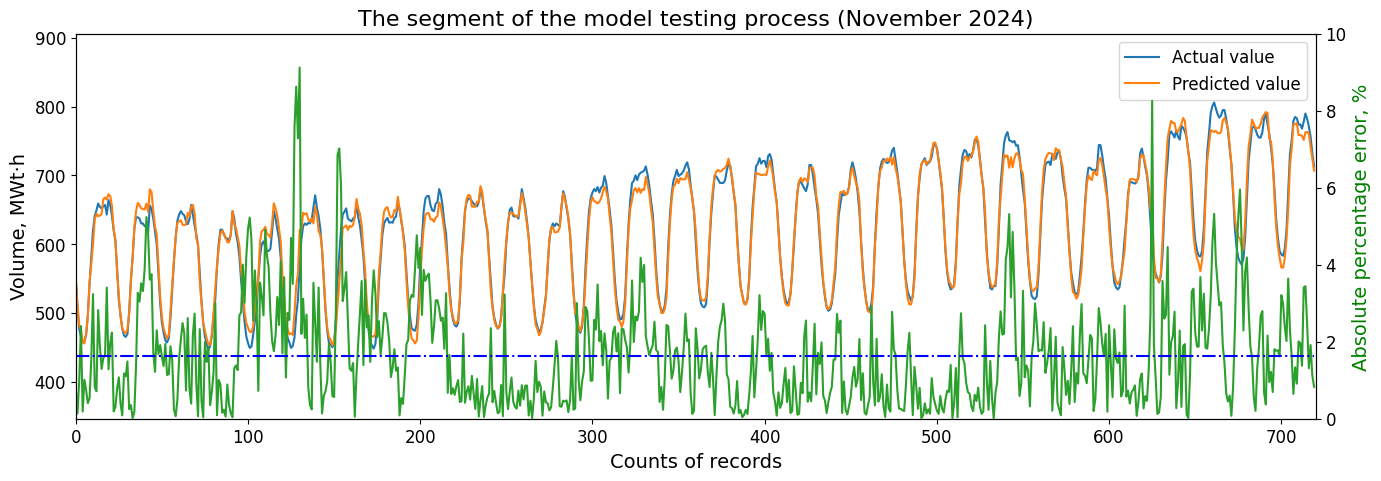

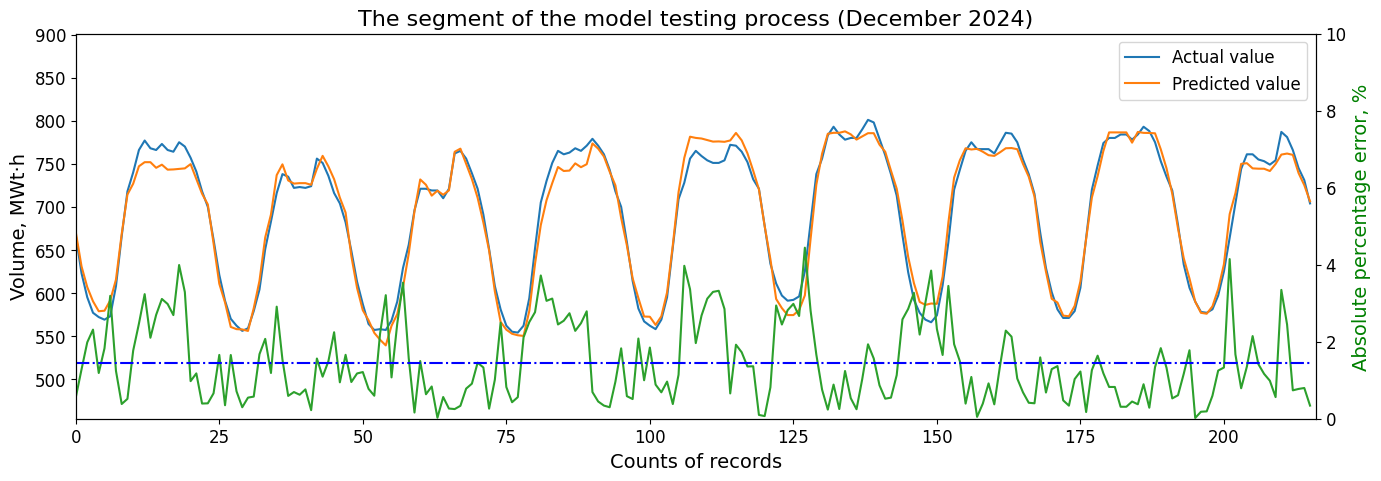

In [143]:
diff_predict_vs_fact(df_validate_result, 11)
diff_predict_vs_fact(df_validate_result, 12)